In [10]:
import kaolin
import torch
import math
import matplotlib
import os

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from io import BytesIO
from PIL import Image
import sdfpred_utils.sdfpred_utils as su
import sdfpred_utils.sdf_MLP as mlp
import sdfpred_utils.sdf_functions as sdf
import sdfpred_utils.loss_functions as lf
import sdfpred_utils.Steik_data2d as sd2d
import sdfpred_utils.Steik_Loss as sl
import sdfpred_utils.Steik_utils as Stu 

#cuda devices
device = torch.device("cuda:0")
print("Using device: ", torch.cuda.get_device_name(device))

#default tensor types
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

multires = 2
input_dims=2
lr_sites = 0.003
lr_model = 0.00005
iterations = 5000
save_every = 100
max_iter = 100
#learning_rate = 0.03
destination = "./images/autograd/multiple_sites/"


Using device:  NVIDIA GeForce RTX 3090


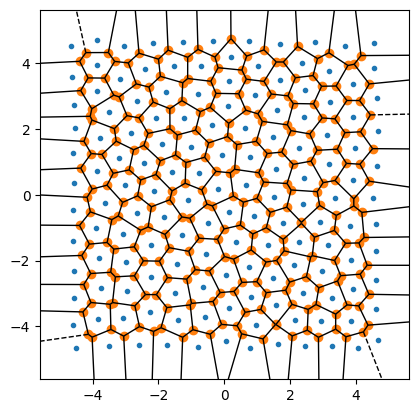

In [11]:
num_centroids = 144
site_fp = f'sites_{num_centroids}_{input_dims}.pt'

if os.path.exists(site_fp):
    sites = torch.load(site_fp)
else:
    sites = su.createCVTgrid(num_centroids=num_centroids, dimensionality=input_dims)
    #save the initial sites torch tensor
    torch.save(sites, site_fp)
    
#plot sites
fig, ax = plt.subplots()
voronoi_plot_2d(Voronoi(sites.detach().cpu().numpy()), ax)
ax.set_aspect('equal')
plt.show()

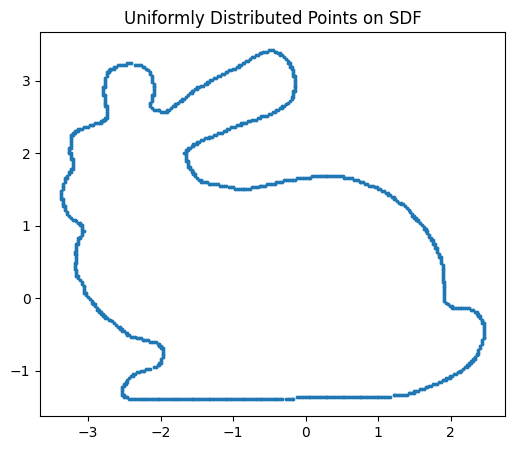

Points shape:  torch.Size([892, 2])


In [12]:
# Generate points
#true_points = generate_rectangle_points(num_points=400, width=1.0, height=1.0, scale=6.0)

sdf_function = sdf.bunny_sdf

true_points = sdf.generate_sdf_points(grid_size=1000, width=20.0, height=20.0, sdf_function=sdf_function, threshold=13e-3)

if sdf_function == sdf.bunny_sdf:
    #shift points to the center
    true_points = true_points - torch.tensor([2,2])
    true_points = true_points * 1.3

if sdf_function == sdf.moon_sdf:
    true_points = true_points + torch.tensor([2,0])
    

# Plot points
plt.figure(figsize=(6, 6))
plt.axes().set_aspect('equal')
plt.scatter(true_points[:, 0].cpu(), true_points[:, 1].cpu(), s=3)
plt.title("Uniformly Distributed Points on SDF")

plt.show()

print("Points shape: ", true_points.shape)

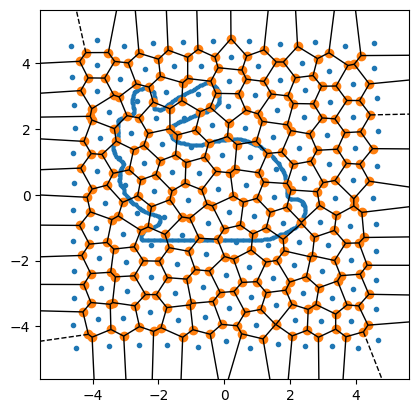

In [13]:
#plot sites
fig, ax = plt.subplots()
voronoi_plot_2d(Voronoi(sites.detach().cpu().numpy()), ax)
ax.scatter(true_points[:, 0].cpu(), true_points[:, 1].cpu(), s=3)
ax.set_aspect('equal')
plt.show()

Manifold points shape:  torch.Size([1, 900, 2])
Normals shape:  torch.Size([1, 900, 2])
Non-manifold distance shape:  torch.Size([1, 900])
Non-manifold points shape:  torch.Size([1, 900, 2])
Manifold points type:  torch.float32
Non-manifold normals shape:  torch.Size([1, 900, 2])


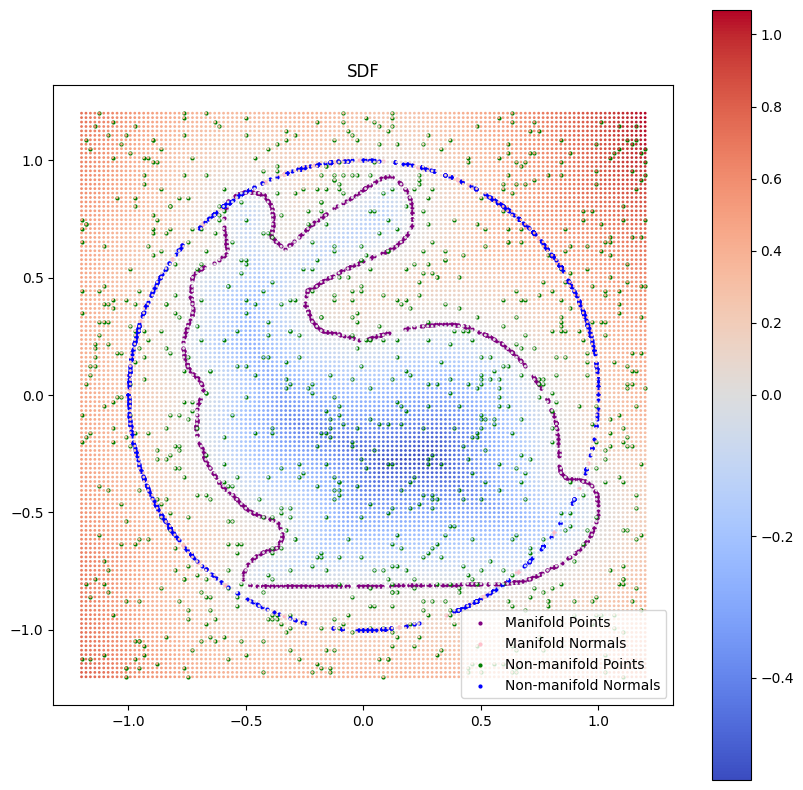

Manifold points shape:  torch.Size([900, 2])
Non-manifold shape:  torch.Size([900, 2])


In [14]:
shape_type = 'bunny'
res = 128 # has to be even
example_idx = 0
sample_type = 'grid'
n_samples = 1
n_points = 900
dataset = sd2d.get2D_dataset(n_points, n_samples, res, sample_type, 0.005, shape_type=shape_type)  # BasicShape2D(100, 20, res=50)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)
data = next(iter(dataloader))

mnfld_points, normals_gt, nonmnfld_dist_gt, nonmnfld_points, nonmnfld_n_gt= data['points'].to(device), data['mnfld_n'].to(device), \
                                                                            data['nonmnfld_dist'].to(device), \
                                                                            data['nonmnfld_points'].to(device), data['nonmnfld_n'].to(device),


print("Manifold points shape: ", mnfld_points.shape)
print("Normals shape: ", normals_gt.shape)
print("Non-manifold distance shape: ", nonmnfld_dist_gt.shape)
print("Non-manifold points shape: ", nonmnfld_points.shape)
#type
print("Manifold points type: ", mnfld_points.dtype)
print("Non-manifold normals shape: ", nonmnfld_n_gt.shape)

#change tensor dtype to float64
mnfld_points = mnfld_points.double()
normals_gt = normals_gt.double()
nonmnfld_dist_gt = nonmnfld_dist_gt.double()
nonmnfld_points = nonmnfld_points.double()
nonmnfld_n_gt = nonmnfld_n_gt.double()


# mnfld_points.requires_grad_()
# nonmnfld_points.requires_grad_()

#plot mnfld points
plt.figure(figsize=(10, 10))
plt.axes().set_aspect('equal')
#plt.scatter(dataset.vertices[:,0], dataset.vertices[:,1], s=1, c = 'black', label='Vertices')

plt.scatter(mnfld_points[0][:, 0].cpu(), mnfld_points[0][:, 1].cpu(), s=4, c = 'purple', label='Manifold Points')
plt.scatter(normals_gt[0][:, 0].cpu(), normals_gt[0][:, 1].cpu(), s=4, c = 'pink', label='Manifold Normals')

plt.scatter(nonmnfld_points[0][:, 0].cpu(), nonmnfld_points[0][:, 1].cpu(), s=4, c = 'green', label='Non-manifold Points')
plt.scatter(nonmnfld_n_gt[0][:, 0].cpu(), nonmnfld_n_gt[0][:, 1].cpu(), s=4, c = 'blue', label='Non-manifold Normals')
norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(dataset.dist_img.flatten()), vcenter=0, vmax=np.max(dataset.dist_img.flatten()))

plt.scatter(dataset.grid_points[:,0], dataset.grid_points[:,1], s=1, c = dataset.dist_img.flatten(), cmap='coolwarm', norm=norm)
plt.colorbar()
plt.legend()

plt.title("SDF")
plt.show()

scale = 3.0
mnfld_points = mnfld_points[0] * scale
normals_gt = normals_gt[0] * scale
nonmnfld_dist_gt = nonmnfld_dist_gt[0] * scale
nonmnfld_points = nonmnfld_points[0] * scale
nonmnfld_n_gt = nonmnfld_n_gt[0] * scale

mnfld_points.requires_grad_()
nonmnfld_points.requires_grad_()
print("Manifold points shape: ", mnfld_points.shape)
print("Non-manifold shape: ", nonmnfld_points.shape)

loaded model


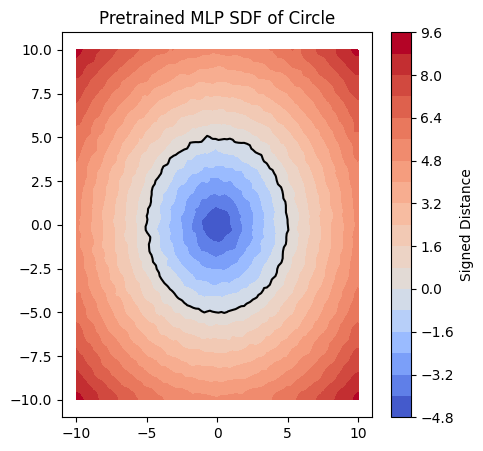

In [15]:

model = mlp.Decoder(multires=multires, input_dims=input_dims).to(device)
#model_path = 'models_resources/pretrained_circle_small.pth'
mlp_rad = 5.0
model_path = f'models_resources/pretrained_circle_{mlp_rad}.pth'

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print('loaded model')
else:
    print("no model found, pretraining")
    model.pre_train_circle(3000, radius=mlp_rad)
    torch.save(model.state_dict(),model_path)

#plot sdf_circle_wave
fig, ax = plt.subplots(figsize=(5, 5))
xx, yy, sdf_values = sdf.plot_sdf(ax, model)

#convert sdf to numpy
sdf_values = sdf_values.cpu().detach().numpy()

norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_values), vcenter=0, vmax=np.max(sdf_values))

# Plot the SDF with the centered colormap
contour = plt.contourf(xx, yy, sdf_values, levels=20, cmap="coolwarm", norm=norm)

# Add a colorbar with label
plt.colorbar(contour, label="Signed Distance")
plt.title("Pretrained MLP SDF of Circle")
plt.xlim(-11, 11)
plt.ylim(-11, 11)

plt.show()


In [16]:
# cvt_loss_values = []
# min_distance_loss_values = []
# edge_smoothing_loss_values = []
# chamfer_distance_loss_values = []
# eikonal_loss_values = []
# domain_restriction_loss_values = []
# zero_true_points_loss_values = []
loss_values = []

def autograd(sites, model, max_iter=100, stop_train_threshold=1e-6, upsampling=0, lambda_weights = [0.1,1.0,0.1,0.1,1.0,1.0,0.1]):
    optimizer = torch.optim.Adam([
    {'params': [p for _, p in model.named_parameters()], 'lr': lr_model},
    #{'params': [sites], 'lr': lr_sites}
], betas=(0.9, 0.999))

    prev_loss = float("inf")
    best_loss = float("inf")
    # upsampled = 0.0
    epoch = 0
    lambda_cvt = lambda_weights[0]
    # lambda_sdf = lambda_weights[1]
    # lambda_min_distance = lambda_weights[2]
    # lambda_laplace = lambda_weights[3]
    lamda_chamfer = lambda_weights[4]
    lamda_eikonal = lambda_weights[5]
    lambda_domain_restriction = lambda_weights[6]
    lambda_true_points = lambda_weights[7]
    lambda_div = 300
    lambda_sdf = 300
    lambda_eikonal = 50
    
    decay_rate = 0.01
    
    best_sites = sites.clone()
    best_sites.best_loss = best_loss
    
    gif_frames = []  # List to store individual frames for GIF
    gif_fn = f'{destination}{max_iter}_Steik_{epoch}.gif'
    fig, ax = plt.subplots(figsize=(5, 5))  # Create a single figure
    
    while epoch <= max_iter:
        optimizer.zero_grad()
        
        # vertices_to_compute, bisectors_to_compute = su.compute_zero_crossing_vertices(sites, model)
        # vertices = su.compute_vertices_2d_vectorized(sites, vertices_to_compute)
        # bisectors = su.compute_all_bisectors_vectorized(sites, bisectors_to_compute)
    
        # # combine vertices and bisectors to one tensor for chamfer
        # points = torch.cat((vertices, bisectors), 0)
        
        # # Compute losses       
        # cvt_loss = lf.compute_cvt_loss(sites)
        # #min_distance_loss = min_distance_regularization_for_op_sites(edges,sites)
        # # min_distance_loss = lf.sdf_weighted_min_distance_loss(model, sites)
        # # edge_smoothing_loss = compute_edge_smoothing_loss(edges, sites, model)
        # chamfer_loss = lf.chamfer_distance(true_points, points)
        # #eikonal_loss = lf.eikonal(model, input_dimensions=input_dims)

        #domain_restriction_loss = lf.domain_restriction(true_points, model)
        
        # sdf_values_true_points = model(true_points)[:,0]
        # zero_true_points_loss_L2 = torch.mean(sdf_values_true_points**2)
        # zero_true_points_loss_L1 = torch.mean(torch.abs(model(true_points)[:, 0]))
        # lambda_1, lambda_2 = 0 , 0.99  # Adjust weights as needed
        # zero_true_points_loss = lambda_1 * zero_true_points_loss_L1 + lambda_2 * zero_true_points_loss_L2
               
        
        # TODO: move loss function into the loop now that i have the data splitted
        # get loss
        #weights=[3e3, 1e2, 1e2, 5e1, 1e2]
        #criterion = sl.Loss(weights=weights,loss_type="siren_wo_n_w_div", div_decay="linear", div_type="dir_l1")


        # output_pred = SINR(nonmnfld_points, mnfld_points)
        # output_pred = {}
        # output_pred["nonmanifold_pnts_pred"] = model(nonmnfld_points)
        # output_pred["manifold_pnts_pred"] = model(mnfld_points)
        
        non_manifold_pred = model(nonmnfld_points)
        manifold_pred = model(mnfld_points)
        # print(f"non_manifold_pred shape: {non_manifold_pred.shape}")
        # print(f"manifold_pred shape: {manifold_pred.shape}")
        
        div_loss = torch.tensor([0.0], device=mnfld_points.device)

        # compute gradients for div (divergence), curl and curv (curvature)
        if manifold_pred is not None:
            mnfld_grad = Stu.gradient(mnfld_points, manifold_pred)
        else:
            mnfld_grad = None

        nonmnfld_grad = Stu.gradient(nonmnfld_points, non_manifold_pred)


        div_loss = torch.abs(lf.directional_div(nonmnfld_points, nonmnfld_grad)).mean() #+ mnfld_divergence_term.mean()

        eikonal_term = lf.eikonal_loss(nonmnfld_grad, mnfld_grad=mnfld_grad, eikonal_type='abs')
        
        sdf_term = torch.abs(manifold_pred).mean()

        print(f"div_loss: {div_loss}, eikonal_term: {eikonal_term}, sdf_term: {sdf_term}")

        model_loss = lambda_sdf*sdf_term + lambda_eikonal*eikonal_term + lambda_div*div_loss 

        #DIVDECAY='linear' # 'linear' | 'quintic' | 'step'
        div_decay_params = [1e2, 0.2, 1e2, 0.4, 0.0, 0.0]
        div_decay_params = [300, 0.5, 100, 0.8, 0.0, 0.0]
        
        
        #div_decay_params=(1e2 0.2 1e2 0.4 0.0 0.0)
        lambda_div = lf.update_div_weight(epoch, max_iter, lambda_div, 'linear', div_decay_params)
        print(f"lambda_div: {lambda_div}")        




        # loss_dict, _ = criterion(output_pred=output_pred, mnfld_points=mnfld_points, 
        #                             nonmnfld_points=nonmnfld_points, mnfld_n_gt=normals_gt)
        # loss = loss_dict["loss"]


        # print(f"loss dict: {loss_dict}")
        # i = -1
        # for key in loss_dict.keys():
        #     if i == -1:
        #         print(f"Loss: {key}: {loss_dict[key]}")
        #     else:
        #         print(f"{key}: {loss_dict[key]*weights[i]}")
        #     i += 1

        # Track raw losses (unweighted)
  
        # sites_loss = (
        #     #lambda_cvt * math.exp(-decay_rate * epoch) * cvt_loss +
        #     lambda_cvt * cvt_loss +
        #     # lambda_min_distance * min_distance_loss + 
        #     #lambda_laplace * edge_smoothing_loss +
        #     lamda_chamfer * chamfer_loss
        #     # lamda_eikonal * eikonal_loss +
        #     # lambda_domain_restriction * domain_restriction_loss +
        #     # lambda_true_points * zero_true_points_loss
        # )
        
        loss = model_loss #+ sites_loss
        # loss_values.append(loss.item())
        print(f"Epoch {epoch}: loss = {loss.item()}")
        
        
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch
            best_sites = sites.clone()
            best_sites.best_loss = best_loss
            # if upsampled > 0:
            #     print(f"UPSAMPLED {upsampled} Best Epoch {best_epoch}: Best loss = {best_loss}")
            #     #return best_sites
        
        if abs(prev_loss - loss.item()) < stop_train_threshold:
            print(f"Converged at epoch {epoch} with loss {loss.item()}")
            #break
        
        prev_loss = loss.item() 
        
        #TODO change how to do upsampling
        # #if epoch>100 and epoch%100 == 1 and upsampled < 2:
        # if epoch>100 and (epoch // 100) == upsampled+1 and loss.item() < 0.5 and upsampled < upsampling:
        #     print("sites length: ",len(sites))
            
        #     new_sites = su.upsampling_inside(best_sites, model)
        #     #new_sites = su.adaptive_density_upsampling(best_sites, model)
        #     print(new_sites)
        #     sites = su.add_upsampled_sites(best_sites, new_sites)
        #     sites = sites.detach().requires_grad_(True)
        #     print("upsampled sites length: ",len(sites))
            
        #     best_sites = sites.clone()
        #     best_sites.best_loss = best_loss
            
        #     optimizer = torch.optim.Adam([{'params': [p for _, p in model.named_parameters()], 'lr': lr_model},
        #                                   {'params': [sites], 'lr': lr_sites}])
        #     upsampled += 1.0

        # Plot Voronoi diagram
        sites_np = sites.detach().cpu().numpy()
        voronoi_initial = Voronoi(sites_np)
        ax.clear()  # Clear the current plot
        voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
        xx, yy, sdf_values = sdf.plot_sdf(ax, model)

        #convert sdf to numpy
        sdf_values = sdf_values.cpu().detach().numpy()

        norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_values), vcenter=0, vmax=np.max(sdf_values))

        # Plot the SDF with the centered colormap
        contour = plt.contourf(xx, yy, sdf_values, levels=20, cmap="coolwarm", norm=norm)

        #ax.scatter(true_points[:,0].cpu(), true_points[:,1].cpu(), color='green', s=1)
        ax.scatter(mnfld_points[:,0].detach().cpu().numpy(), mnfld_points[:,1].detach().cpu().numpy(), color='green', s=1)

        #plot vertices
        # ax.scatter(vertices[:,0].detach().cpu().numpy(), vertices[:,1].detach().cpu().numpy(), color='red', s=30)
        # ax.scatter(bisectors[:,0].detach().cpu().numpy(), bisectors[:,1].detach().cpu().numpy(), color='yellow', s=30)
      
        ax.set_title(f"Epoch {epoch} - Loss: {loss:.4f}")
        
        # Save the current figure to an in-memory buffer
        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        
        # Append the buffer content as an image frame
        gif_frames.append(Image.open(buf))
                        
        if epoch % (max_iter/10) == 0:
            print(f"Epoch {epoch}: loss = {loss.item()}")
            print(f"Best Epoch {best_epoch}: Best loss = {best_loss}")
            # Save the GIF
            gif_frames[0].save(
                f'{destination}{max_iter}_Steik_{epoch}.gif',
                save_all=True,            
                append_images=gif_frames[1:],
                duration=100,  # Duration in ms between frames
                loop=0
            )
            print("GIF saved as ",f'{destination}{max_iter}_Steik_{epoch}.gif')
                    
        epoch += 1
            
    # Save the GIF
    gif_frames[0].save(
        gif_fn,
        save_all=True,
        append_images=gif_frames[1:],
        duration=100,  # Duration in ms between frames
        loop=0
    )
    print("GIF saved as ", gif_fn)
            
        
    return best_sites

div_loss: 5.554361799454291, eikonal_term: 0.34766619419983846, sdf_term: 2.6799029162141363
lambda_div: 300
Epoch 0: loss = 2487.6627244105202
Epoch 0: loss = 2487.6627244105202
Best Epoch 0: Best loss = 2487.6627244105202
GIF saved as  ./images/autograd/multiple_sites/5000_Steik_0.gif
div_loss: 5.536178362614915, eikonal_term: 0.36675495816753684, sdf_term: 2.565716227415197
lambda_div: 299.92
Epoch 1: loss = 2448.90612491741
div_loss: 5.509446502971135, eikonal_term: 0.3920673557140322, sdf_term: 2.4506688853933594
lambda_div: 299.84
Epoch 2: loss = 2407.197228574812
div_loss: 5.485885677724972, eikonal_term: 0.4191462261177843, sdf_term: 2.3347788996673233
lambda_div: 299.76
Epoch 3: loss = 2366.2789428151414
div_loss: 5.458411030522115, eikonal_term: 0.4463886827829151, sdf_term: 2.2178560428649696
lambda_div: 299.68
Epoch 4: loss = 2323.889537507946
div_loss: 5.419251547298029, eikonal_term: 0.4792936297415501, sdf_term: 2.099904146188634
lambda_div: 299.6
Epoch 5: loss = 2277.97

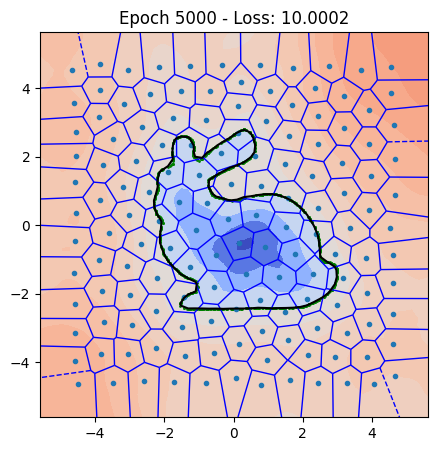

In [17]:
lambda_weights = [1,1,1,1,10,1,0.000001,100]

lambda_cvt = lambda_weights[0]
lambda_sdf = lambda_weights[1]
lambda_min_distance = lambda_weights[2]
lambda_laplace = lambda_weights[3]
lamda_chamfer = lambda_weights[4]
lambda_eikonal = lambda_weights[5]
lambda_domain_restriction = lambda_weights[6]
lambda_true_points = lambda_weights[7]

max_iter = 5000

site_file_path = f'{destination}{max_iter}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}_eikonal_{lambda_eikonal}.npy'
#check if optimized sites file exists
if os.path.exists(site_file_path):
    #import sites
    print("Importing sites")
    sites = np.load(site_file_path)
    sites = torch.from_numpy(sites).to(device).requires_grad_(True)
else:
    sites = autograd(sites, model, max_iter=max_iter, upsampling=0, lambda_weights=lambda_weights)
    sites_np = sites.detach().cpu().numpy()
    np.save(site_file_path, sites_np)
    

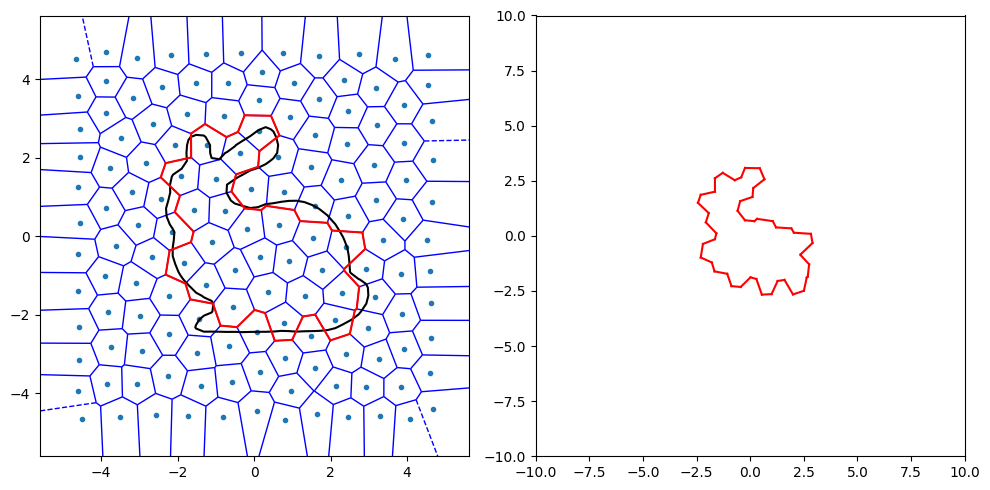

In [18]:
edges = su.get_sites_zero_crossing_edges(sites, model)

sites_np = sites.detach().cpu().numpy()
# Compute Voronoi diagram
vor = Voronoi(sites_np)

# Create two subplots: one with Voronoi diagram and one without
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot with Voronoi diagram
ax1 = axs[0]
voronoi_plot_2d(vor, ax=ax1, show_vertices=False, line_colors='blue')
sdf.plot_sdf(ax1, model)

#ax1.set_title("With Voronoi Diagram")

# Plot edges
for vertex1, vertex2 in edges:
    v1 = vor.vertices[vertex1]
    v2 = vor.vertices[vertex2]
    ax1.plot([v1[0], v2[0]], [v1[1], v2[1]], 'r-')

#ax1.legend(['Zero-crossing edges'], loc='upper right')
# Plot without Voronoi diagram
ax2 = axs[1]
#plot_sdf(ax2, model)
#ax2.set_title("Without Voronoi Diagram")
#plt.triplot(*zip(*sites_np), 'o', markersize=3, color='blue')
# Plot edges
for vertex1, vertex2 in edges:
    v1 = vor.vertices[vertex1]
    v2 = vor.vertices[vertex2]
    ax2.plot([v1[0], v2[0]], [v1[1], v2[1]], 'r-')
#ax2.legend(['Zero-crossing edges'], loc='upper right')
# plt.plot([], [], 'r-', label='sites zero-crossing edge')
# limit of the plot
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.tight_layout()
plt.savefig(f'{destination}edge_sdf_crossing.png')

plt.show()    

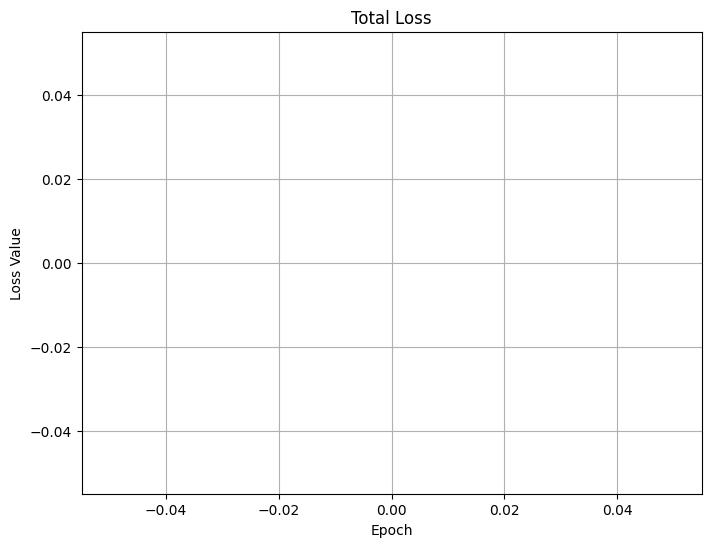

In [19]:
# Plot the final loss
plt.figure(figsize=(8, 6))
plt.plot(range(len(loss_values)), loss_values)
plt.title("Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.grid(True)
plt.show()
